## 1. Importar Librerías

Importamos las librerías necesarias para análisis SHAP y carga de modelos.

In [15]:
# Comments in English, concise and human
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import joblib
import os
import sys

# Add parent directory to path for imports
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src import data_processing

# Configure matplotlib for better plots
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 2. Cargar Datos de Validación

Regeneramos los datos procesados usando el pipeline completo para obtener X_val con las mismas transformaciones que se usaron en el entrenamiento.

In [16]:
# Load processed data using the same pipeline as training
print("📂 Loading processed data...")
train, val, test, tscv = data_processing.prepare_full_pipeline()

# Load rolling windows configuration from saved model
MODELS_DIR = os.path.join(os.getcwd(), '..', 'models')
rolling_windows = joblib.load(os.path.join(MODELS_DIR, 'rolling_windows.pkl'))

print(f"✅ Rolling windows loaded: {rolling_windows}")

# Define features dynamically based on rolling_windows
features = [
    "shop_cluster",
    "item_category_id",
    "item_price_log",
    "item_cnt_lag_1_log",
    "item_cnt_lag_2_log",
    "item_cnt_lag_3_log",
    "price_rel_category",
    "price_rel_category_log",
    "price_discount",
    "is_new_price",
    "price_change_pct",
    "price_change_2m_pct",
    "revenue_potential_log",
    "price_demand_elasticity",
]

# Add rolling window features
for window in rolling_windows:
    features.append(f"rolling_mean_{window}")
    features.append(f"rolling_std_{window}")

target = "target_log"

# Extract validation set
X_val = val[features]
y_val = val[target]

print(f"✅ Data loaded: X_val shape = {X_val.shape}, y_val shape = {y_val.shape}")
print(f"📊 Features used: {len(features)}")

📂 Loading processed data...
✅ Ventanas rolling validadas: [3, 6]
✅ Usando archivos locales desde data/
📂 Cargando archivos CSV...
✅ Datos cargados exitosamente (600 registros de ventas)
🧹 Limpiando datos...
🤖 Generando Clusters (K-Means)...
⚙️ Ingeniería de Características (Lags + Rolling Windows [3, 6])...
🔥 Generando features de MOMENTUM...
💰 Generando features de SENSIBILIDAD AL PRECIO...
✅ Ventanas rolling validadas: [3, 6]
✅ Features de rolling window creadas (ventanas: [3, 6])
📊 Generando features de DESVIACIÓN respecto a promedios...
✅ Ventanas rolling validadas: [3, 6]
📐 Aplicando normalización a variables de precio y ventas...
✅ Feature Engineering completado: 41 columnas, 600 filas
📅 Configurando Time Series Split (ventana temporal)...
📊 Dataset listo: Train (500), Val (50), Test (50)
🔄 TimeSeriesSplit configurado con 5 splits para validación cruzada
✅ Rolling windows loaded: [3, 6]
✅ Data loaded: X_val shape = (50, 18), y_val shape = (50,)
📊 Features used: 18


## 3. Cargar Modelo Compatible con TreeExplainer

Cargamos el modelo `stacking_model.pkl` y extraemos el primer estimador base (RandomForest o XGBoost) que es compatible con `TreeExplainer`.

Si el modelo stacking no tiene estimadores base compatibles, cargamos el modelo `xgb_simple_shap.pkl` como fallback.

In [17]:
# Load stacking model
stacking_model = joblib.load(os.path.join(MODELS_DIR, 'stacking_model.pkl'))

print(f"✅ Stacking model loaded: {type(stacking_model).__name__}")

# Extract tree-based model for SHAP (TreeExplainer requirement)
model = None

if hasattr(stacking_model, "estimators_"):
    # Get base estimators from stacking model
    base_estimators = stacking_model.estimators_
    
    print(f"📋 Base estimators found: {len(base_estimators)}")
    for i, estimator in enumerate(base_estimators):
        print(f"   {i+1}. {type(estimator).__name__}")
    
    # Use first tree-based estimator (RandomForest or XGBoost)
    for estimator in base_estimators:
        if hasattr(estimator, "tree_") or hasattr(estimator, "estimators_"):
            model = estimator
            print(f"✅ Using {type(model).__name__} for SHAP analysis")
            break
else:
    # Direct model (not stacking)
    if hasattr(stacking_model, "tree_") or hasattr(stacking_model, "estimators_"):
        model = stacking_model
        print(f"✅ Using direct model {type(model).__name__} for SHAP")

# Fallback to simple XGBoost model if no tree-based model found
if model is None:
    xgb_path = os.path.join(MODELS_DIR, 'xgb_simple_shap.pkl')
    if os.path.exists(xgb_path):
        model = joblib.load(xgb_path)
        print(f"✅ Using fallback XGBoost model for SHAP: {type(model).__name__}")
    else:
        raise ValueError("No tree-based model found for SHAP analysis")

print(f"\n🎯 Model ready: {type(model).__name__}")

✅ Stacking model loaded: StackingRegressor
📋 Base estimators found: 2
   1. RandomForestRegressor
   2. XGBRegressor
✅ Using RandomForestRegressor for SHAP analysis

🎯 Model ready: RandomForestRegressor


## 4. Calcular Valores SHAP con TreeExplainer

Usamos `shap.TreeExplainer` para calcular los valores SHAP que explican las predicciones del modelo.

In [18]:
# Create SHAP TreeExplainer
print("🔍 Creating SHAP TreeExplainer...")
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for validation set
print("⚙️ Calculating SHAP values (this may take a moment)...")
shap_values = explainer.shap_values(X_val)

# Handle multi-output models (e.g., multi-class classification)
if isinstance(shap_values, list):
	shap_values = shap_values[0]  # Use first output for regression or binary classification

# Extract scalar base value if it's an array
base_value = explainer.expected_value
if isinstance(base_value, np.ndarray):
	base_value = base_value[0] if base_value.size > 0 else base_value.item()

print(f"✅ SHAP values calculated: shape = {shap_values.shape}")
print(f"   - Base value (expected value): {base_value:.4f}")

🔍 Creating SHAP TreeExplainer...
⚙️ Calculating SHAP values (this may take a moment)...
✅ SHAP values calculated: shape = (50, 18)
   - Base value (expected value): 1.7467


## 5. Visualización: SHAP Summary Plot

Generamos el **summary plot** que muestra:
- **Eje Y**: Características ordenadas por importancia
- **Eje X**: Valor SHAP (impacto en la predicción)
- **Color**: Valor de la característica (rojo = alto, azul = bajo)
- **Puntos**: Cada punto representa una observación

Este gráfico responde: *¿Qué características tienen mayor impacto en las predicciones y en qué dirección?*

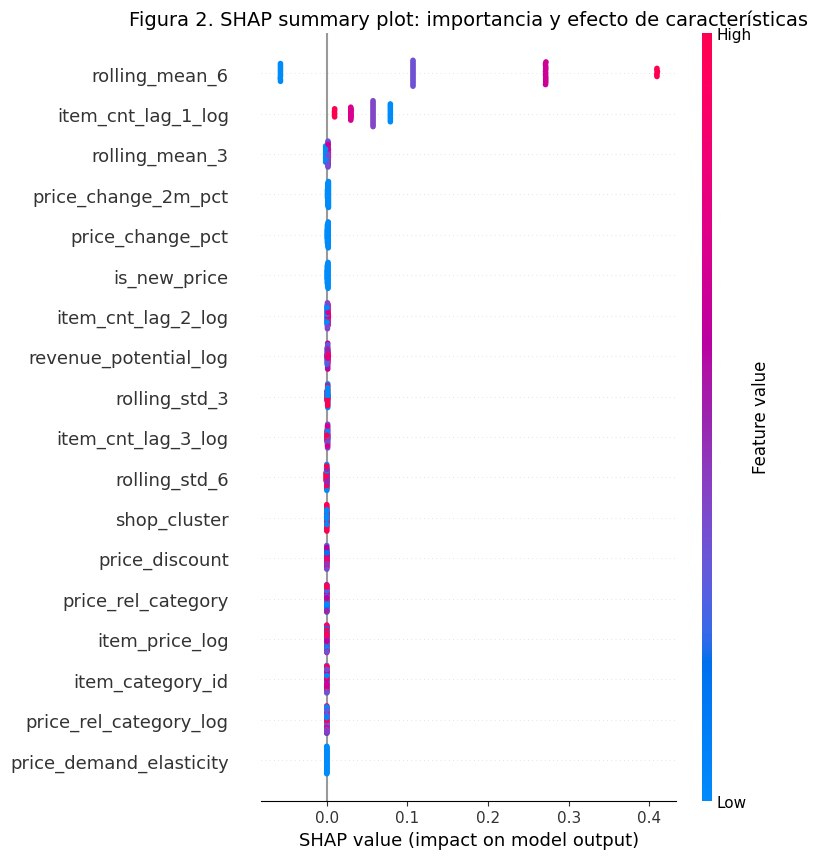

✅ SHAP summary plot generated


In [19]:
# Plot SHAP summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_val, plot_type="dot", show=False)
plt.title("Figura 2. SHAP summary plot: importancia y efecto de características", fontsize=14)
plt.tight_layout()
plt.show()

print("✅ SHAP summary plot generated")

## 6. Análisis Adicional: Feature Importance

Calculamos la importancia promedio absoluta de cada característica usando SHAP.

📊 Top 10 características más importantes (SHAP):

              feature  importance
       rolling_mean_6    0.180763
   item_cnt_lag_1_log    0.048571
       rolling_mean_3    0.001590
  price_change_2m_pct    0.001548
     price_change_pct    0.001326
         is_new_price    0.001106
   item_cnt_lag_2_log    0.001026
revenue_potential_log    0.000989
        rolling_std_3    0.000957
   item_cnt_lag_3_log    0.000836


<Figure size 1000x600 with 0 Axes>

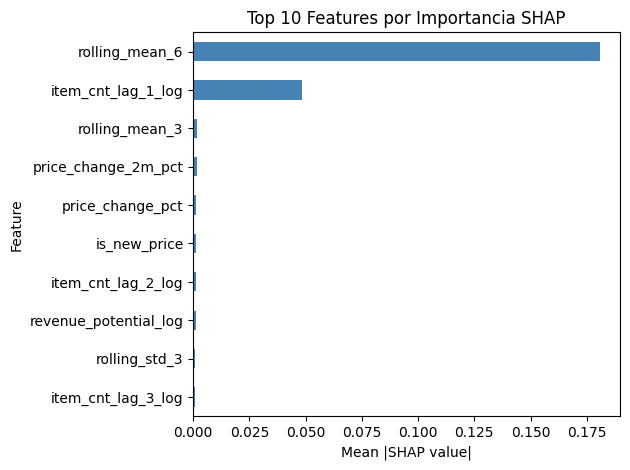

In [20]:
# Calculate mean absolute SHAP values for feature importance
shap_importance = pd.DataFrame({
    'feature': X_val.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False)

print("📊 Top 10 características más importantes (SHAP):\n")
print(shap_importance.head(10).to_string(index=False))

# Plot bar chart
plt.figure(figsize=(10, 6))
shap_importance.head(10).plot(x='feature', y='importance', kind='barh', color='steelblue', legend=False)
plt.xlabel('Mean |SHAP value|')
plt.ylabel('Feature')
plt.title('Top 10 Features por Importancia SHAP')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 7. Análisis de Dependencia: Feature Seleccionada

Analizamos cómo una característica específica afecta las predicciones en función de su valor, visualizando su interacción con otras features.

🔍 Analizando dependencia de la característica: rolling_mean_6


<Figure size 1000x600 with 0 Axes>

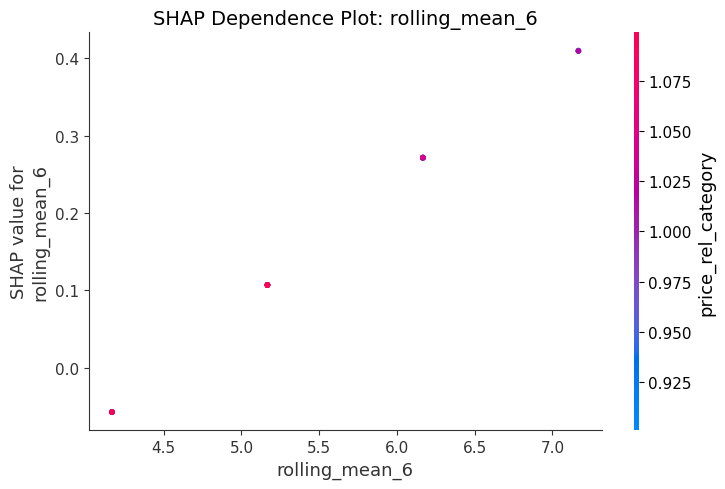

✅ Dependence plot generado para 'rolling_mean_6'


In [21]:
# Select top feature for dependence plot
top_feature = shap_importance.iloc[0]['feature']

print(f"🔍 Analizando dependencia de la característica: {top_feature}")

# SHAP dependence plot
plt.figure(figsize=(10, 6))
shap.dependence_plot(
    top_feature, 
    shap_values, 
    X_val, 
    show=False
)
plt.title(f"SHAP Dependence Plot: {top_feature}", fontsize=14)
plt.tight_layout()
plt.show()

print(f"✅ Dependence plot generado para '{top_feature}'")

## 8. Explicación Individual: Waterfall Plot

Seleccionamos una predicción específica y mostramos cómo cada característica contribuyó a esa predicción usando un **waterfall plot**.

📝 Explicando predicción para muestra #0
   - Valor real (log-scale): 1.9213
   - Valor real (original scale): 5.83 unidades


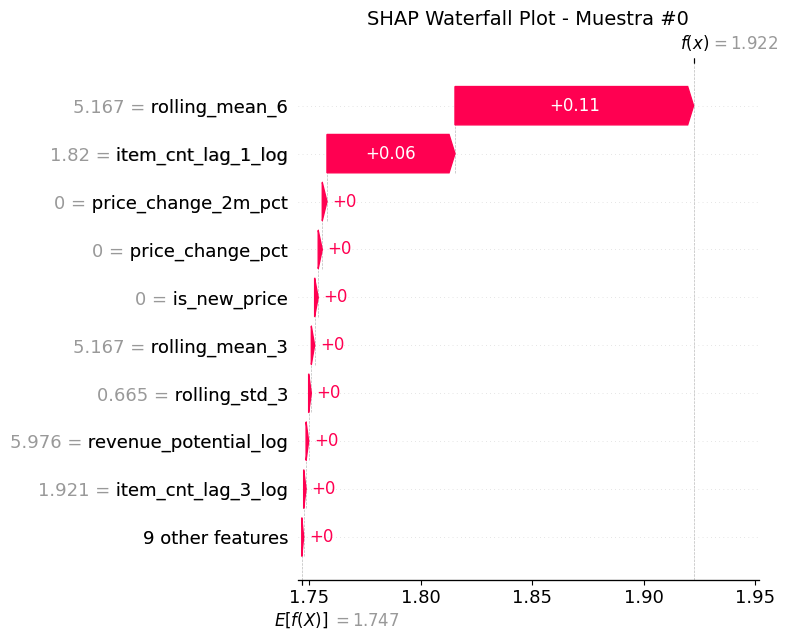

✅ Waterfall plot generado


In [22]:
# Select a sample for individual explanation
sample_idx = 0  # First validation sample

print(f"📝 Explicando predicción para muestra #{sample_idx}")
print(f"   - Valor real (log-scale): {y_val.iloc[sample_idx]:.4f}")
print(f"   - Valor real (original scale): {np.expm1(y_val.iloc[sample_idx]):.2f} unidades")

# Create Explanation object for waterfall plot
shap_explanation = shap.Explanation(
    values=shap_values[sample_idx],
    base_values=explainer.expected_value,
    data=X_val.iloc[sample_idx].values,
    feature_names=X_val.columns.tolist()
)

# Waterfall plot
plt.figure(figsize=(10, 8))
shap.waterfall_plot(shap_explanation, show=False)
plt.title(f"SHAP Waterfall Plot - Muestra #{sample_idx}", fontsize=14)
plt.tight_layout()
plt.show()

print("✅ Waterfall plot generado")

## 9. Conclusiones

**Interpretaciones clave del análisis SHAP**:

1. **Importancia de Features**: Las características con mayor impacto promedio en las predicciones.
2. **Dirección del Efecto**: Valores altos de una feature aumentan (rojo) o disminuyen (azul) la predicción.
3. **Interacciones**: El dependence plot revela cómo una feature interactúa con otras.
4. **Explicaciones Individuales**: El waterfall plot muestra el "porqué" de predicciones específicas.

**Uso en producción**: Estos análisis SHAP se integran en la aplicación Streamlit (`app/services/prediction_service.py`) para ofrecer explicabilidad en tiempo real.

---
**Nota**: Este notebook usa `shap.TreeExplainer` exclusivamente, garantizando interpretaciones precisas para modelos basados en árboles de decisión.

## 10. Exportar Insumos para Análisis Técnico

Exportamos todos los archivos necesarios para análisis de desempeño, distribución de errores y explicabilidad:

- `metrics_overall.csv`: Métricas globales por modelo y split
- `predictions_<model>_val.csv`: Predicciones con verdad terreno y residuales
- `features_val.csv`: Features usadas (para reproducibilidad)
- `shap_summary_<model>_val.csv`: Resumen de importancia SHAP

In [23]:
# Create exports directory
EXPORTS_DIR = os.path.join(os.getcwd(), '..', 'exports')
os.makedirs(EXPORTS_DIR, exist_ok=True)

print(f"📁 Exports directory: {EXPORTS_DIR}")

# ===========================
# 1. Export metrics_overall.csv
# ===========================
import json

metrics_path = os.path.join(MODELS_DIR, 'metrics.json')
if os.path.exists(metrics_path):
    with open(metrics_path, 'r') as f:
        metrics_data = json.load(f)
    
    # Convert to DataFrame
    metrics_list = []
    
    # Check if metrics_data is a list or dict
    if isinstance(metrics_data, list):
        # If it's already a list of metrics, use it directly
        metrics_list = metrics_data
        # Ensure each entry has the required fields
        for item in metrics_list:
            if 'split' not in item:
                item['split'] = 'val'
            if 'model_size_mb' not in item:
                item['model_size_mb'] = None
    elif isinstance(metrics_data, dict):
        # If it's a dict, iterate over items
        for model_name, model_metrics in metrics_data.items():
            metrics_list.append({
                'model': model_name,
                'split': 'val',  # Current metrics are validation metrics
                'rmse': model_metrics.get('rmse', None),
                'mae': model_metrics.get('mae', None),
                'r2': model_metrics.get('r2', None),
                'train_time_s': model_metrics.get('train_time', None),
                'model_size_mb': None  # Will be calculated from .pkl files
            })
    
    metrics_df = pd.DataFrame(metrics_list)
    
    # Map model names to actual file names
    model_file_map = {
        'Random Forest': 'stacking_model.pkl',  # RF is part of stacking
        'XGBoost': 'xgb_simple_shap.pkl',
        'Stacking Ensemble': 'stacking_model.pkl',
        'MLP': 'mlp_model.keras',
        'LSTM-DNN': 'lstm_model.keras'
    }
    
    # Calculate model sizes
    for idx, row in metrics_df.iterrows():
        model_name = row['model']
        
        # Try exact file name from map
        if model_name in model_file_map:
            model_file = os.path.join(MODELS_DIR, model_file_map[model_name])
        else:
            # Fallback: try converting model name to filename
            model_file = os.path.join(MODELS_DIR, f"{model_name.lower().replace(' ', '_')}_model.pkl")
        
        if os.path.exists(model_file):
            size_mb = os.path.getsize(model_file) / (1024 * 1024)
            metrics_df.at[idx, 'model_size_mb'] = round(size_mb, 2)
            print(f"  ✓ {model_name}: {size_mb:.2f} MB")
        else:
            print(f"  ✗ {model_name}: file not found ({os.path.basename(model_file)})")
    
    output_path = os.path.join(EXPORTS_DIR, 'metrics_overall.csv')
    metrics_df.to_csv(output_path, index=False)
    print(f"✅ Exported: metrics_overall.csv")
    print(f"   Models: {len(metrics_df)}")
else:
    print("⚠️ metrics.json not found")

# ===========================
# 2. Export predictions with residuals
# ===========================

# Load all models
models_to_export = {
    'randomforest': os.path.join(MODELS_DIR, 'stacking_model.pkl'),  # Use stacking which contains RF
    'xgboost': os.path.join(MODELS_DIR, 'xgb_simple_shap.pkl'),
    'stacking': os.path.join(MODELS_DIR, 'stacking_model.pkl'),
}

for model_name, model_path in models_to_export.items():
    if os.path.exists(model_path):
        try:
            loaded_model = joblib.load(model_path)
            
            # For stacking model, extract base estimator for RF
            if model_name == 'randomforest' and hasattr(loaded_model, 'estimators_'):
                # Get first base estimator (RandomForest)
                loaded_model = loaded_model.estimators_[0]
            
            # Generate predictions
            y_pred_log = loaded_model.predict(X_val)
            
            # Convert back to original scale
            y_true_original = np.expm1(y_val)
            y_pred_original = np.expm1(y_pred_log)
            
            # Create predictions DataFrame
            predictions_df = pd.DataFrame({
                'y_true': y_true_original.values,
                'y_pred': y_pred_original,
                'residual': y_true_original.values - y_pred_original,
                'shop_cluster': val['shop_cluster'].values,
                'item_category_id': val['item_category_id'].values,
                'date_block_num': val['date_block_num'].values
            })
            
            output_path = os.path.join(EXPORTS_DIR, f'predictions_{model_name}_val.csv')
            predictions_df.to_csv(output_path, index=False)
            print(f"✅ Exported: predictions_{model_name}_val.csv")
            print(f"   Samples: {len(predictions_df)}, RMSE: {np.sqrt(np.mean(predictions_df['residual']**2)):.4f}")
            
        except Exception as e:
            print(f"⚠️ Failed to export {model_name}: {str(e)}")
    else:
        print(f"⚠️ Model file not found: {model_path}")

# ===========================
# 3. Export features_val.csv
# ===========================
features_df = X_val.copy()
features_df['shop_cluster'] = val['shop_cluster'].values
features_df['item_category_id'] = val['item_category_id'].values
features_df['date_block_num'] = val['date_block_num'].values
features_df['target_log'] = y_val.values

output_path = os.path.join(EXPORTS_DIR, 'features_val.csv')
features_df.to_csv(output_path, index=False)
print(f"✅ Exported: features_val.csv")
print(f"   Samples: {len(features_df)}, Features: {len(X_val.columns)}")

# ===========================
# 4. Export SHAP summary
# ===========================

# Calculate mean absolute SHAP values
shap_summary_df = pd.DataFrame({
    'feature': X_val.columns,
    'mean_abs_shap_value': np.abs(shap_values).mean(axis=0),
    'mean_shap_value': shap_values.mean(axis=0),
    'std_shap_value': shap_values.std(axis=0)
}).sort_values('mean_abs_shap_value', ascending=False)

shap_summary_df['rank'] = range(1, len(shap_summary_df) + 1)

# Determine model name used for SHAP
shap_model_name = type(model).__name__.lower()
if 'random' in shap_model_name or 'forest' in shap_model_name:
    shap_model_name = 'randomforest'
elif 'xgb' in shap_model_name:
    shap_model_name = 'xgboost'

output_path = os.path.join(EXPORTS_DIR, f'shap_summary_{shap_model_name}_val.csv')
shap_summary_df.to_csv(output_path, index=False)
print(f"✅ Exported: shap_summary_{shap_model_name}_val.csv")
print(f"   Features: {len(shap_summary_df)}")
print(f"\n📊 Top 5 features by SHAP importance:")
print(shap_summary_df[['rank', 'feature', 'mean_abs_shap_value']].head(5).to_string(index=False))

# ===========================
# 5. Export segments map
# ===========================
segments_df = val[['shop_cluster', 'item_category_id', 'date_block_num']].drop_duplicates()

# Add cluster names
cluster_map = {0: "Tienda Pequeña", 1: "Supermercado Mediano", 2: "Megatienda"}
segments_df['cluster_name'] = segments_df['shop_cluster'].map(cluster_map)

output_path = os.path.join(EXPORTS_DIR, 'segments_map.csv')
segments_df.to_csv(output_path, index=False)
print(f"✅ Exported: segments_map.csv")
print(f"   Unique segments: {len(segments_df)}")

print(f"\n🎉 All exports completed! Check: {EXPORTS_DIR}")

📁 Exports directory: /Users/egarv/UNAB/Asignaturas/Sexto Trimestre/Aprendizaje de Maquina/Sumativa 2/notebooks/../exports
  ✓ Random Forest: 0.63 MB
  ✓ XGBoost: 0.07 MB
  ✓ MLP: 0.20 MB
  ✓ LSTM-DNN: 0.09 MB
  ✓ Stacking Ensemble: 0.63 MB
✅ Exported: metrics_overall.csv
   Models: 5
✅ Exported: predictions_randomforest_val.csv
   Samples: 50, RMSE: 0.0325
✅ Exported: predictions_xgboost_val.csv
   Samples: 50, RMSE: 0.3112
✅ Exported: predictions_stacking_val.csv
   Samples: 50, RMSE: 0.7440
✅ Exported: features_val.csv
   Samples: 50, Features: 18
✅ Exported: shap_summary_randomforest_val.csv
   Features: 18

📊 Top 5 features by SHAP importance:
 rank             feature  mean_abs_shap_value
    1      rolling_mean_6             0.180763
    2  item_cnt_lag_1_log             0.048571
    3      rolling_mean_3             0.001590
    4 price_change_2m_pct             0.001548
    5    price_change_pct             0.001326
✅ Exported: segments_map.csv
   Unique segments: 8

🎉 All expo